# Loading data

In [1]:
import os 
os.getcwd()

'c:\\Users\\Alex\\Documents\\repos\\Predicting-ATP-Tennis-Match-Outcomes\\Python'

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
X_train = pd.read_csv("Temp data/X_train.csv", sep=",")
X_test = pd.read_csv("Temp data/X_test.csv", sep=",")
y_train = pd.read_csv("Temp data/y_train.csv", sep=",")
y_test = pd.read_csv("Temp data/y_test.csv", sep=",")

## Preprocessing

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.impute import SimpleImputer, KNNImputer

num_var = ['rank_diff','age_diff','height_diff','Rolling_WLR_diff','Rolling_WLR_5_diff','Rolling_SVP_diff',
           'Rolling_SVP_5_diff','Rolling_SSWP_diff','Rolling_SSWP_5_diff','Rolling_BPS_diff','Rolling_BPS_5_diff']

cat_var = ["draw_size", "surface", "tourney_level"]

numeric_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ("diff_standardize", StandardScaler())

])

cat_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ("onehot_cat", OneHotEncoder(sparse_output=False, categories='auto', drop='first', handle_unknown='ignore'))

])


preprocessor1 = ColumnTransformer([
 ('numeric', numeric_pipe, num_var),
 ('categorical', cat_pipe, cat_var)   
], remainder="drop")



# Gradient-boosting model

In [4]:

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


gbm = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", HistGradientBoostingClassifier())
    ]
)
gbm.fit(X_train,y_train)
gbm_pred = gbm.predict_proba(X_test)[:,1]



## Confusion-matrix and AUC

The response variable is, by construction, perfectly balanced and therefore it seems sufficient to consider the Accuracy as the main validation metric. 

[[6650 3709]
 [3816 6713]]


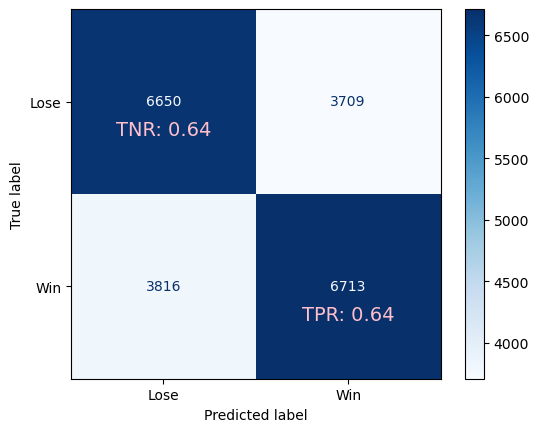

In [5]:
import matplotlib.pyplot as plt
gbm_pred_label = [1 if val >= 0.5 else 0 for val in gbm_pred]
gbm_confusion = confusion_matrix(y_test,gbm_pred_label)
print(gbm_confusion)
# Calculate true positive rate (sensitivity)
TPR = gbm_confusion[1, 1] / (gbm_confusion[1, 1] + gbm_confusion[1, 0])
TNR = gbm_confusion[0, 0] / (gbm_confusion[0, 0] + gbm_confusion[0, 1])
Accuracy = (gbm_confusion[1, 1] +gbm_confusion[0, 0]) /(gbm_confusion[0, 0] + gbm_confusion[1, 0]+gbm_confusion[0, 1] + gbm_confusion[1, 1])
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=gbm_confusion, display_labels=['Lose', 'Win'])
disp.plot(cmap='Blues', values_format='d')  # Adjust the colormap and format as needed

# Add text for true positive rate
plt.text(1, 1.1, f'TPR: {TPR:.2f}', color='pink', fontsize=14, va='top', ha='center')
plt.text(0, 0.1, f'TNR: {TNR:.2f}', color='pink', fontsize=14, va='top', ha='center')

# Show the plot
plt.show()

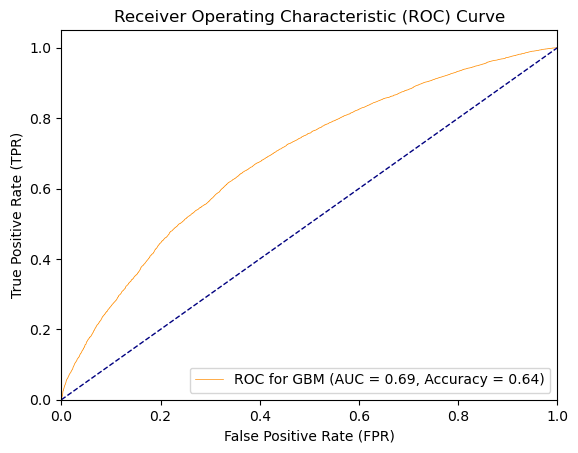

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error
fpr1, tpr1, thresholds = roc_curve(y_test, gbm_pred)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='darkorange', lw=.5, label=f'ROC for GBM (AUC = {roc_auc1:.2f}, Accuracy = {Accuracy:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The Accuracy metric measures the overall accuracy of our model, i.e. the number of correct classifications out of the total number of classifications, and can be extracted from the confusion matrix. 
\begin{equation*}
\text{Accuracy} = \dfrac{TP+TN}{P+N}
\end{equation*}.

The accuracy of the GBM is 0.66, which implies that the model is a 32% improvement over randomly guessing a winner.

## Variable importance from Random Forest classifier

In [ ]:
%%capture captured
from sklearn.ensemble import RandomForestClassifier
X_train_subset = X_train.sample(n = 5000, random_state = 1)
y_train_subset = y_train.loc[X_train_subset.index]


forest = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", RandomForestClassifier())
    ]
)

forest.fit(X_train,y_train)

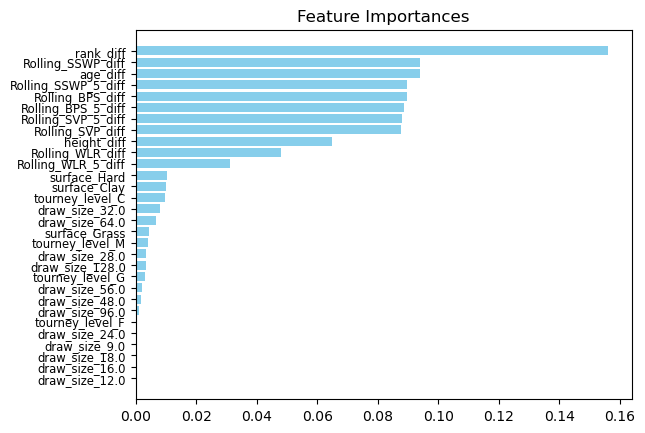

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
importances = forest.named_steps["regressor"].feature_importances_
indices = np.argsort(importances)[::1]
features = forest.named_steps["preprocessor"].get_feature_names_out()
features = [name.split('__')[-1] for name in features]
features_int = range(len(features))  
plt.barh(features_int, importances[indices], align="center", color = 'skyblue')  # Create horizontal bar plot
plt.yticks(features_int, np.array(features)[indices], fontsize = 'small')  # Set y-axis tick labels
plt.title("Feature Importances")
plt.show()


The difference in ranking ,rather obviously, has a high impact on the outcome. Other variables of importance include:
- The difference in rolling second serve win percentage
- The difference in age
- The difference in rolling first serve percentage
- The difference in rolling break points saved percentage
- The difference in height
- The difference in rolling win-loss ratio

# XGBoost

In [7]:
import xgboost as xgb
xgb_clf = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", xgb.XGBClassifier())
    ]
)
xgb_clf.fit(X_train,y_train)
xgb_pred = xgb_clf.predict_proba(X_test)[:,1]



[[6575 3784]
 [3927 6602]]


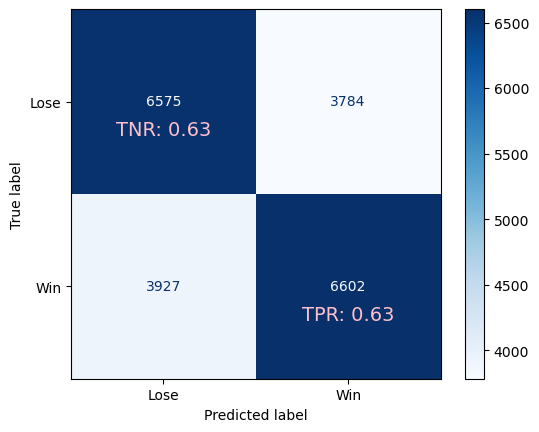

In [8]:
xgb_pred_label = [1 if val >= 0.5 else 0 for val in xgb_pred]
xgb_confusion = confusion_matrix(y_test,xgb_pred_label)
print(xgb_confusion)
# Calculate true positive rate (sensitivity)
TPR = xgb_confusion[1, 1] / (xgb_confusion[1, 1] + xgb_confusion[1, 0])
TNR = xgb_confusion[0, 0] / (xgb_confusion[0, 0] + xgb_confusion[0, 1])
Accuracy = (xgb_confusion[1, 1] +xgb_confusion[0, 0]) /(xgb_confusion[0, 0] + xgb_confusion[1, 0]+xgb_confusion[0, 1] + xgb_confusion[1, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_confusion, display_labels=['Lose', 'Win'])
disp.plot(cmap='Blues', values_format='d')  # Adjust the colormap and format as needed

# Add text for TPR and TNR
plt.text(1, 1.1, f'TPR: {TPR:.2f}', color='pink', fontsize=14, va='top', ha='center')
plt.text(0, 0.1, f'TNR: {TNR:.2f}', color='pink', fontsize=14, va='top', ha='center')

# Show the plot
plt.show()

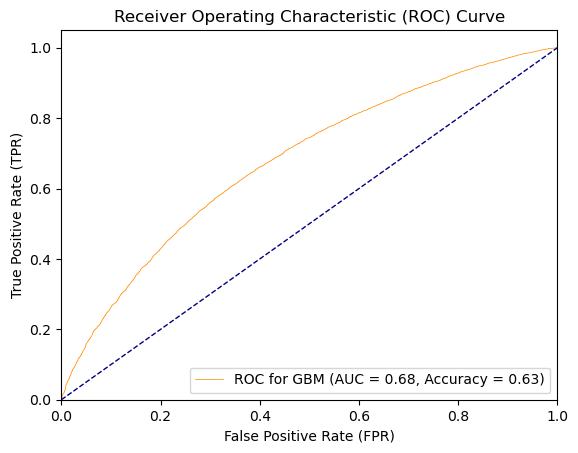

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error
fpr1, tpr1, thresholds = roc_curve(y_test, xgb_pred)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='darkorange', lw=.5, label=f'ROC for GBM (AUC = {roc_auc1:.2f}, Accuracy = {Accuracy:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Partial dependence plots (PDP'S)

In [ ]:

from sklearn.inspection import PartialDependenceDisplay 

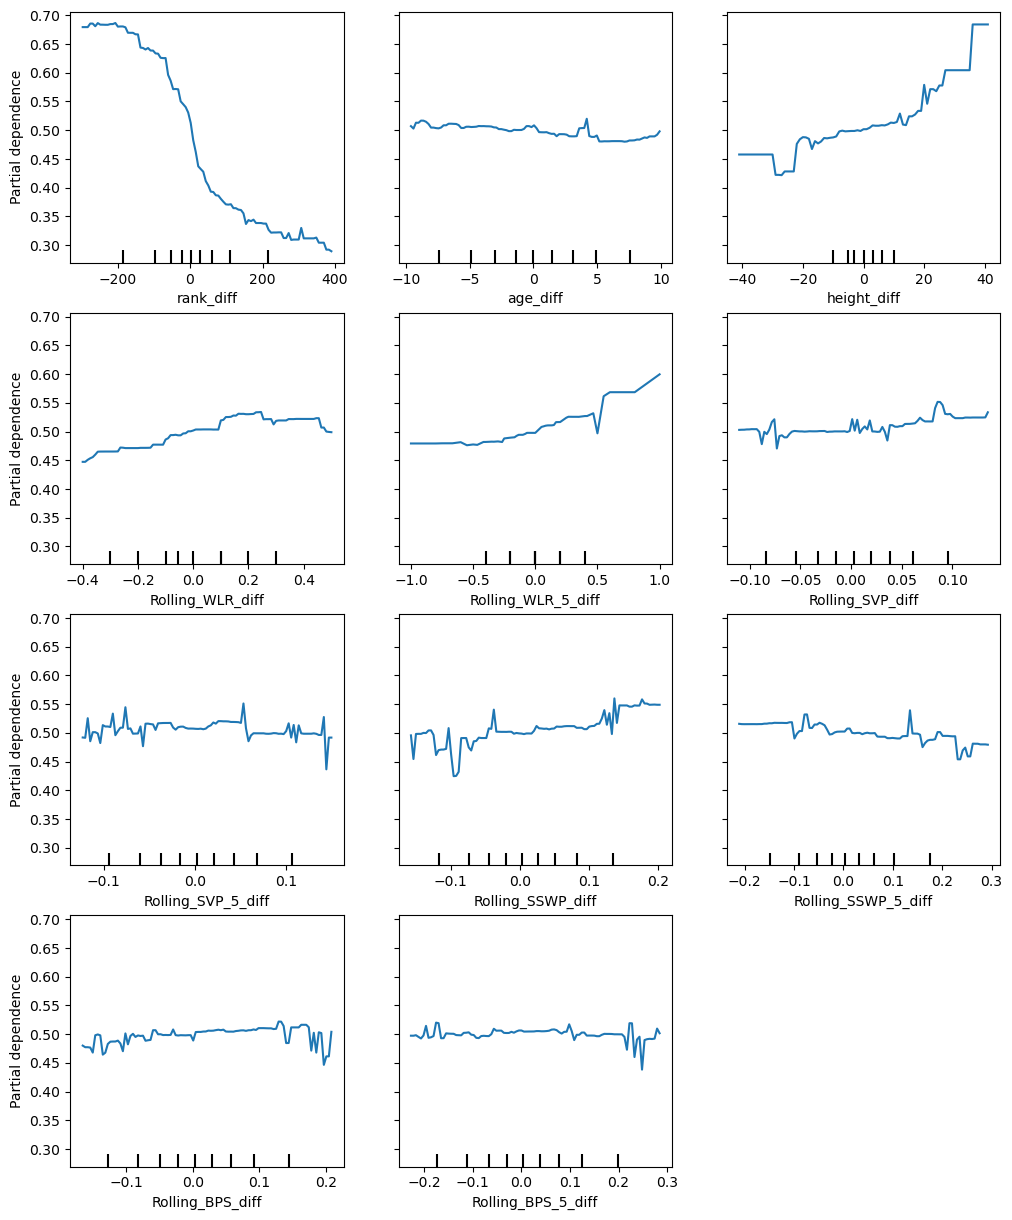

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12, 15))
PartialDependenceDisplay.from_estimator(
    estimator = xgb_clf,
    features = num_var, 
    X = X_train,
    ax = ax)
plt.show() #

# Neural networks

# Is difference in ranking a sufficient predictor?

In [10]:
from sklearn.metrics import accuracy_score
import xgboost as xgb

def model_complex(num_vars, cat_vars):
  preprocessor = ColumnTransformer([
    ('numeric', numeric_pipe, num_vars),
    ('categorical', cat_pipe, cat_vars)
  ], remainder="drop")

  xgb_clf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBClassifier())
  ])
  xgb_clf.fit(X_train, y_train)
  y_pred = xgb_clf.predict(X_test)
  #return y_pred
  accuracy = round(accuracy_score(y_test, y_pred),3)
  print("Accuracy:", accuracy)




In [11]:

a0 = model_complex(num_vars=["rank_diff"],cat_vars=[]) # only rank_diff
a1 = model_complex(num_vars=num_var,cat_vars=cat_var) # rank_diff + all other variabbles
print(a0,a1)


Accuracy: 0.634
Accuracy: 0.631
None None


We see that there is little difference in the accuracy score, when considering all variables against a model with only the difference in rating.

# Hyper-parameter tuning

In [70]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import xgboost as xgb 

In [75]:

param_dist = {
    'regressor__max_depth': stats.randint(3, 10),
    'regressor__learning_rate': stats.uniform(0.01, 0.1),
    'regressor__subsample': stats.uniform(0.5, 1),
    'regressor__n_estimators':stats.randint(100, 600)
}

xgb_model  = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", xgb.XGBClassifier())
    ]
)

# Create the RandomizedSearchCV object
best_fit_GBM = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=4, cv=3, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
best_fit_GBM.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", best_fit_GBM .best_params_)
print("Best score: ", best_fit_GBM .best_score_)


Best set of hyperparameters:  {'regressor__learning_rate': 0.07957324857014436, 'regressor__max_depth': 3, 'regressor__n_estimators': 141, 'regressor__subsample': 0.5983195159846219}
Best score:  0.6363941536286292


## Saving tuned model using pickle

In [76]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "XGBoost_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(best_fit_GBM , file)

### Accuracy of the tuned model on safer side predictions

In [12]:
import pickle
loaded_model = pickle.load(open("XGBoost_model.pkl"  , 'rb'))

import numpy as np
y_test = np.array(y_test).reshape(-1)
xgb_pred = loaded_model.predict_proba(X_test)[:,1]

data = pd.DataFrame({'y_test': y_test, 'xgb_pred' : xgb_pred.flatten() })
data = data[(data['xgb_pred'] >= 0.7) | (data['xgb_pred'] <= 0.3)]
data['xgb_pred_cat'] = data['xgb_pred'].apply(lambda x: 1 if x >= 0.5 else 0)

from sklearn.metrics import accuracy_score

## Calculate accuracy
mis = round(1 - accuracy_score(data['y_test'], data['xgb_pred_cat']),2)

print(f"Misclassification rate for safe-side predictions: {mis:.2f}")

Misclassification rate for safe-side predictions: 0.24


### Calibration plot for tuned model

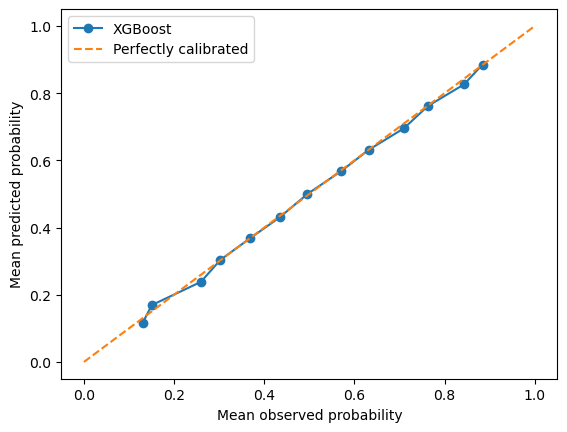

In [78]:
from sklearn.calibration import calibration_curve
xgb_pred = best_fit_GBM.predict_proba(X_test)[:,1]
res = calibration_curve(y_test, xgb_pred, n_bins=15)
plt.plot(res[0], res[1], marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean observed probability')
plt.ylabel('Mean predicted probability')
plt.legend()

# Bootstrapping models

In [ ]:

bootstrap_models = []

# Number of bootstrap repetitions
B = 300

# Bootstrap sampling and model fitting
for i in range(B):
 print(i)
 bootstrap_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
 X_boot = X_train.loc[bootstrap_indices]
 y_boot = y_train.loc[bootstrap_indices]

 params = {k.replace("regressor__", ""): round(v,2) for k, v in loaded_model.best_params_.items()}
# print(params)
 
 xgb_model  = Pipeline(
  
    [
        ("preprocessor",preprocessor1),
        ("regressor", xgb.XGBClassifier(
         **params
         ))
    ]
)
 
 model = xgb_model.fit(X_boot, y_boot)
 bootstrap_models.append(model)

### Saving bootstrapped models

In [15]:
excluded_indices = []
for i in range(len(bootstrap_models)):
    try:
        bootstrap_models[i].predict_proba(X_train)[:,1]
    except ValueError:
        excluded_indices.append(i)

bootstrap_models = [bootstrap_models[i] for i in range(len(bootstrap_models)) if i not in excluded_indices]


In [16]:
import pickle

model_pkl_file = "bootstrap_models.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(bootstrap_models , file)